#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2127994/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v05/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install efficientnet_pytorch
# !pip install pytorch-dpn-pretrained
from efficientnet_pytorch import EfficientNet
import torch.hub

##Define runtime

In [5]:
# !pip install ipython-autotime
%load_ext autotime

time: 258 µs (started: 2024-09-03 13:45:01 -04:00)


##Define GPU usage

In [6]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 367 ms (started: 2024-09-03 13:45:01 -04:00)


In [7]:
# Set the GPU device
gpu_index = 1  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 1: Tesla K80
time: 17.2 ms (started: 2024-09-03 13:45:02 -04:00)


#DATA PREPARATION

##Get and Import dataset

In [8]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 2.89 ms (started: 2024-09-03 13:45:02 -04:00)


###Meta-data

In [9]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

image  age_approx anatom_site_general    lesion_id     sex
0      ISIC_0000000        55.0      anterior torso          NaN  female
1      ISIC_0000001        30.0      anterior torso          NaN  female
2      ISIC_0000002        60.0     upper extremity          NaN  female
3      ISIC_0000003        30.0     upper extremity          NaN    male
4      ISIC_0000004        80.0     posterior torso          NaN    male
...             ...         ...                 ...          ...     ...
25326  ISIC_0073247        85.0           head/neck  BCN_0003925  female
25327  ISIC_0073248        65.0      anterior torso  BCN_0001819    male
25328  ISIC_0073249        70.0     lower extremity  BCN_0001085    male
25329  ISIC_0073251        55.0         palms/soles  BCN_0002083  female
25330  ISIC_0073254        50.0     upper extremity  BCN_0001079    male

[25331 rows x 5 columns]

time: 74.9 ms (started: 2024-09-03 13:45:02 -04:00)


In [10]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 10 columns]

time: 49.4 ms (started: 2024-09-03 13:45:02 -04:00)


In [11]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

image  age_approx anatom_site_general     sex
0     ISIC_0034321        60.0                 NaN  female
1     ISIC_0034322        70.0      anterior torso    male
2     ISIC_0034323        70.0     lower extremity    male
3     ISIC_0034324        70.0     lower extremity    male
4     ISIC_0034325        30.0     upper extremity  female
...            ...         ...                 ...     ...
8233  ISIC_0073236        75.0      anterior torso    male
8234  ISIC_0073243        65.0     lower extremity    male
8235  ISIC_0073250        30.0      anterior torso  female
8236  ISIC_0073252        85.0           head/neck  female
8237  ISIC_0073253        70.0      anterior torso    male

[8238 rows x 4 columns]

time: 19.8 ms (started: 2024-09-03 13:45:02 -04:00)


###Meta-data information

In [12]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 11 ms (started: 2024-09-03 13:45:02 -04:00)


In [13]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 8.83 ms (started: 2024-09-03 13:45:02 -04:00)


In [14]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 6.09 ms (started: 2024-09-03 13:45:02 -04:00)


##DATA PREPROCESSING

###Original data information

In [15]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 11.1 ms (started: 2024-09-03 13:45:02 -04:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [16]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 42 ms (started: 2024-09-03 13:45:02 -04:00)


In [17]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 30 ms (started: 2024-09-03 13:45:02 -04:00)


In [18]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/soles   BCN_0002083  female   
25330              ISIC_0073254   50   upper extremity   BCN_0001079    male   

      Disease_Type  Presence                      Diagnosis  
1459            NV       1.0               Melanocytic Nevi  
1460            NV       1.0               Melanocytic Nevi  
1461            NV       1.0               Melanocytic Nevi  
1462            NV       1.0               Melanocytic Nevi  
1463            NV       1.0               Melanocytic Nevi  
...            ...       ...                            ...  
25326          BCC       1.0           Basal Cell Carcinoma  
25327          BKL       1.0  Benign Keratosis-Like Lesions  
25328          MEL       1.0                       Melanoma  
25329           NV       1.0               Melanocytic Nevi  
25330          BKL       1.0  Benign Keratosis-Like Lesions  

[21311 rows x 8 columns]

time: 22.7 ms (started: 2024-09-03 13:45:02 -04:00)


###Get images data

finish preprocessing

In [19]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/soles   BCN_0002083  female   
25330              ISIC_0073254   50   upper extremity   BCN_0001079    male   

      Disease_Type  Presence                      Diagnosis  \
1459            NV       1.0               Melanocytic Nevi   
1460            NV       1.0               Melanocytic Nevi   
1461            NV       1.0               Melanocytic Nevi   
1462            NV       1.0               Melanocytic Nevi   
1463            NV       1.0               Melanocytic Nevi   
...            ...       ...                            ...   
25326          BCC       1.0           Basal Cell Carcinoma   
25327          BKL       1.0  Benign Keratosis-Like Lesions   
25328          MEL       1.0                       Melanoma   
25329           NV       1.0               Melanocytic Nevi   
25330          BKL       1.0  Benign Keratosis-Like Lesions   

                                              Image_path  
1459   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1460   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1461   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1462   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1463   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
...                                                  ...  
25326  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25327  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25328  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25329  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25330  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  

[21311 rows x 9 columns]

time: 9.07 s (started: 2024-09-03 13:45:02 -04:00)


In [20]:
# train_metadata_pp = train_metadata_pp.sample(n=5000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 17.2 ms (started: 2024-09-03 13:45:11 -04:00)


###Correctting image paths

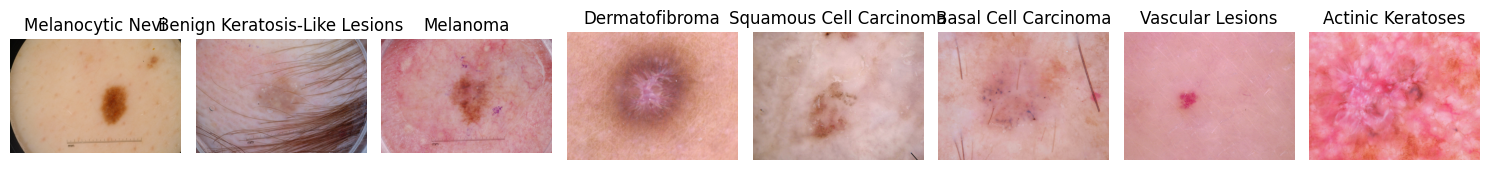

time: 29 s (started: 2024-09-03 13:45:11 -04:00)


In [21]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [22]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 5.14 ms (started: 2024-09-03 13:45:40 -04:00)


###Augment and transfrom dataset

In [23]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 19.5 ms (started: 2024-09-03 13:45:40 -04:00)


###Split data

In [24]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 21.4 ms (started: 2024-09-03 13:45:40 -04:00)


###Balancing dataset

In [25]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 52.9 ms (started: 2024-09-03 13:45:40 -04:00)


###Load training dataset

In [26]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([2, 7, 1, 6, 0, 3, 4, 7, 2, 7, 7, 4, 1, 6, 4, 0, 6, 6, 4, 4, 4, 5, 2, 5,
        5, 6, 5, 2, 4, 5, 3, 5])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 2.21 s (started: 2024-09-03 13:45:40 -04:00)


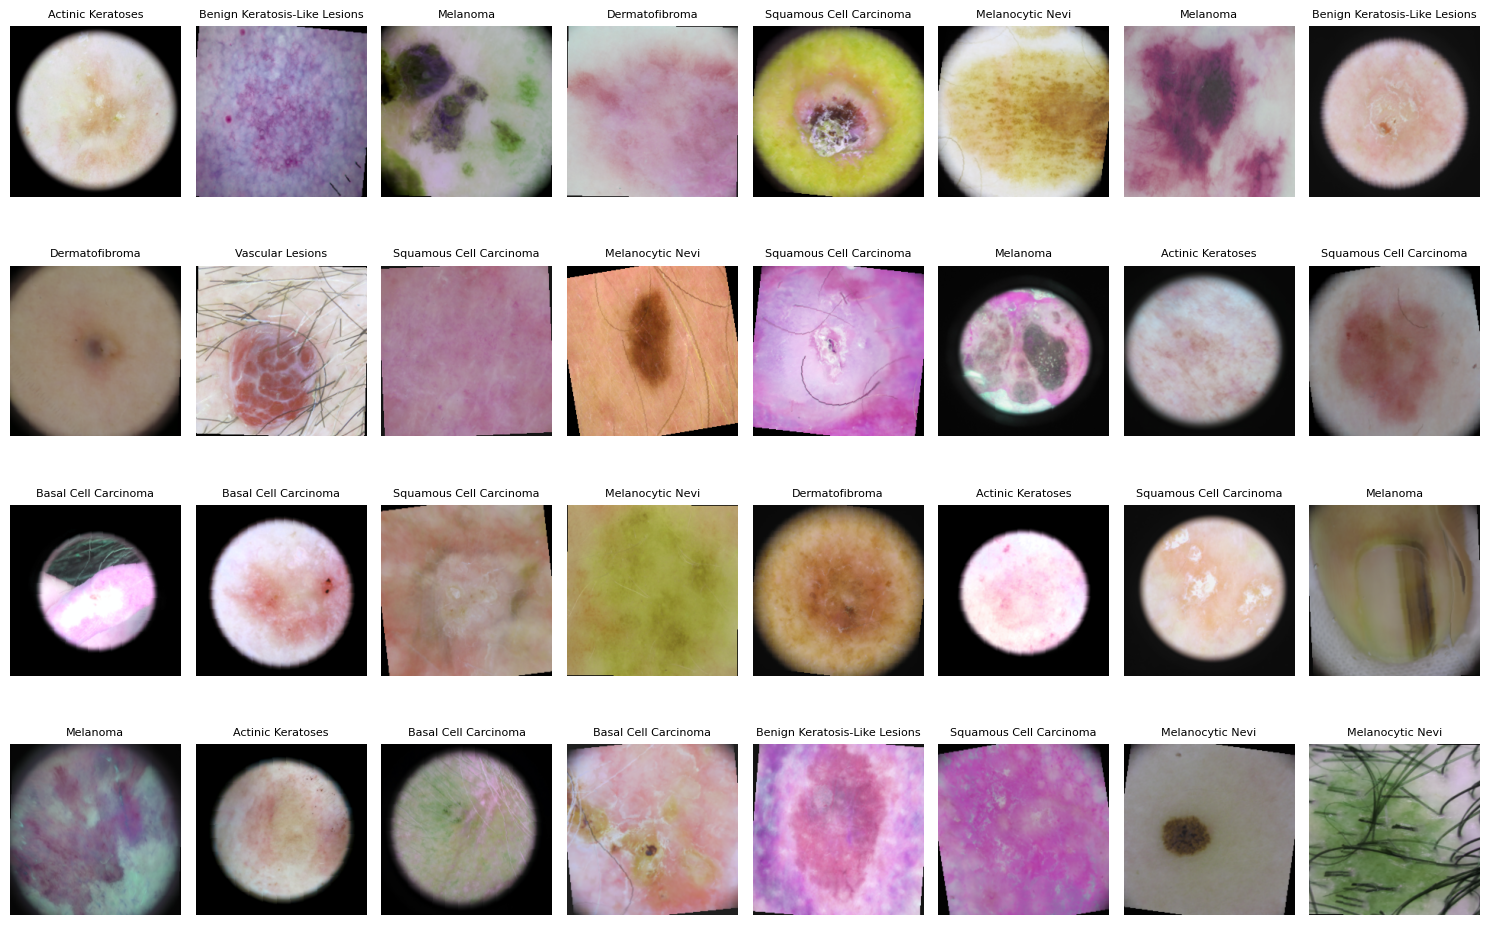

time: 4.47 s (started: 2024-09-03 13:45:42 -04:00)


In [27]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Prepare test data for ensemble model predictions

###Original data information

In [28]:
test_metadata.info()
print()
test_metadata
# print(test_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB



image  age_approx anatom_site_general     sex
0     ISIC_0034321        60.0                 NaN  female
1     ISIC_0034322        70.0      anterior torso    male
2     ISIC_0034323        70.0     lower extremity    male
3     ISIC_0034324        70.0     lower extremity    male
4     ISIC_0034325        30.0     upper extremity  female
...            ...         ...                 ...     ...
8233  ISIC_0073236        75.0      anterior torso    male
8234  ISIC_0073243        65.0     lower extremity    male
8235  ISIC_0073250        30.0      anterior torso  female
8236  ISIC_0073252        85.0           head/neck  female
8237  ISIC_0073253        70.0      anterior torso    male

[8238 rows x 4 columns]

time: 17 ms (started: 2024-09-03 13:45:47 -04:00)


###Data cleansing

In [29]:
# Removing duplicate rows
test_metadata_pp = test_metadata.drop_duplicates()

# Removing rows with missing values
test_metadata_pp = test_metadata_pp.dropna()

# Fixing column names
test_metadata_pp = test_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'sex': 'Sex'
})

# Replace missing values in 'age' column with median age
median_age = test_metadata_pp['Age'].median()
test_metadata_pp['Age'] = test_metadata_pp['Age'].fillna(median_age)

# Convert the Age column to integers
test_metadata_pp['Age'] = test_metadata_pp['Age'].astype(int)

# Add a placeholder Diagnosis column
test_metadata_pp['Diagnosis'] = 'Unknown'

test_metadata_pp.info()
print()
test_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 7537 entries, 1 to 8237
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Image_Id           7537 non-null   object
 1   Age                7537 non-null   int64 
 2   Region_Of_Disease  7537 non-null   object
 3   Sex                7537 non-null   object
 4   Diagnosis          7537 non-null   object
dtypes: int64(1), object(4)
memory usage: 353.3+ KB



Image_Id  Age Region_Of_Disease     Sex Diagnosis
1     ISIC_0034322   70    anterior torso    male   Unknown
2     ISIC_0034323   70   lower extremity    male   Unknown
3     ISIC_0034324   70   lower extremity    male   Unknown
4     ISIC_0034325   30   upper extremity  female   Unknown
5     ISIC_0034326   80         head/neck    male   Unknown
...            ...  ...               ...     ...       ...
8233  ISIC_0073236   75    anterior torso    male   Unknown
8234  ISIC_0073243   65   lower extremity    male   Unknown
8235  ISIC_0073250   30    anterior torso  female   Unknown
8236  ISIC_0073252   85         head/neck  female   Unknown
8237  ISIC_0073253   70    anterior torso    male   Unknown

[7537 rows x 5 columns]

time: 34.9 ms (started: 2024-09-03 13:45:47 -04:00)


###Get images data

finish preprocessing

In [30]:
# Load test images
test_image_paths = [os.path.join(test_input_dir, fname) for fname in os.listdir(test_input_dir)]
test_image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in test_image_paths}
test_metadata_pp['Image_path'] = test_metadata_pp['Image_Id'].map(test_image_path_dict)

test_metadata_pp.info()
print()
test_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 7537 entries, 1 to 8237
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Image_Id           7537 non-null   object
 1   Age                7537 non-null   int64 
 2   Region_Of_Disease  7537 non-null   object
 3   Sex                7537 non-null   object
 4   Diagnosis          7537 non-null   object
 5   Image_path         7537 non-null   object
dtypes: int64(1), object(5)
memory usage: 412.2+ KB



Image_Id  Age Region_Of_Disease     Sex Diagnosis  \
1     ISIC_0034322   70    anterior torso    male   Unknown   
2     ISIC_0034323   70   lower extremity    male   Unknown   
3     ISIC_0034324   70   lower extremity    male   Unknown   
4     ISIC_0034325   30   upper extremity  female   Unknown   
5     ISIC_0034326   80         head/neck    male   Unknown   
...            ...  ...               ...     ...       ...   
8233  ISIC_0073236   75    anterior torso    male   Unknown   
8234  ISIC_0073243   65   lower extremity    male   Unknown   
8235  ISIC_0073250   30    anterior torso  female   Unknown   
8236  ISIC_0073252   85         head/neck  female   Unknown   
8237  ISIC_0073253   70    anterior torso    male   Unknown   

                                             Image_path  
1     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
2     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
3     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
4     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
5     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
...                                                 ...  
8233  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8234  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8235  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8236  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8237  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  

[7537 rows x 6 columns]

time: 2.95 s (started: 2024-09-03 13:45:47 -04:00)


###Load test data

In [31]:
# Use test_metadata
class LoadedTestDatasetToPredict(Dataset):
    def __init__(self, dataframe, transform=None, is_test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            label = self.dataframe.iloc[idx]['Diagnosis_Label']
            return image, label

time: 2.02 ms (started: 2024-09-03 13:45:50 -04:00)


In [32]:
# Define the transformation for the test dataset
prediction_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Create the test dataset
prediction_test_dataset = LoadedTestDatasetToPredict(test_metadata_pp, transform=prediction_test_transform, is_test=True)

# Create the test dataloader
prediction_test_loader = DataLoader(prediction_test_dataset, batch_size=32, shuffle=False, num_workers=4)

time: 13.8 ms (started: 2024-09-03 13:45:50 -04:00)


Total number of images in the test dataset: 2132


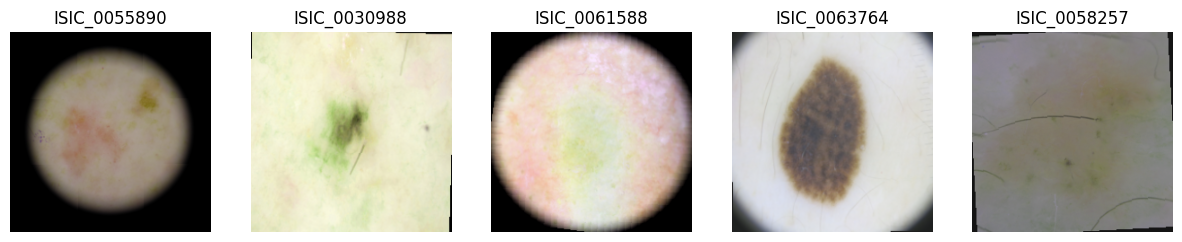

time: 625 ms (started: 2024-09-03 13:45:50 -04:00)


In [33]:
def show_test_images(dataset, num_images=5):
   
    total_images = len(dataset)
    print(f"Total number of images in the test dataset: {total_images}")
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        idx = random.randint(0, total_images - 1)
        image = dataset[idx]
        
        if isinstance(image, tuple):
            image = image[0]  # If the dataset returns a tuple (image, label), take only the image
        
        image_name = dataset.dataframe.iloc[idx]['Image_Id']
        
        image = image.permute(1, 2, 0)  # Change the order of dimensions for plotting
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"{image_name}")
        plt.axis('off')
    
    plt.show()

# Use the function to display images from the test dataset
show_test_images(test_dataset, num_images=5)


##Model functionalities

###Construct models

In [34]:
# def create_model(model_name, num_classes):
#     if model_name == 'resnet50':
#         model = models.resnet50(pretrained=True)
#         num_ftrs = model.fc.in_features
#         model.fc = nn.Sequential(
#             nn.Dropout(0.5),  # Add dropout with 50% probability
#             nn.Linear(num_ftrs, num_classes)
#         )
#     elif model_name == 'densenet121':
#         model = models.densenet121(pretrained=True)
#         num_ftrs = model.classifier.in_features
#         model.classifier = nn.Sequential(
#             nn.Dropout(0.5),  # Add dropout with 50% probability
#             nn.Linear(num_ftrs, num_classes)
#         )
#     elif model_name == 'efficientnet-b0':
#         model = EfficientNet.from_pretrained('efficientnet-b0')
#         num_ftrs = model._fc.in_features
#         model._fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(num_ftrs, num_classes)
#         )
#     elif model_name == 'resnext50_32x4d':
#         model = models.resnext50_32x4d(pretrained=True)
#         num_ftrs = model.fc.in_features
#         model.fc = nn.Sequential(
#             nn.Dropout(0.5),  # Add dropout with 50% probability
#             nn.Linear(num_ftrs, num_classes)
#         )
#         model.num_classes = num_classes
#     elif model_name == 'shufflenet_v2_x1_0':
#         model = models.shufflenet_v2_x1_0(pretrained=True)
#         num_ftrs = model.fc.in_features
#         model.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(num_ftrs, num_classes)
#         )
#     elif model_name == 'dpn68':
#         model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn68', pretrained=True)
#         num_ftrs = model.classifier.in_features
#         model.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(num_ftrs, num_classes)
#         )
#     elif model_name == 'customCNN':
#         model = CustomCNN(num_classes)
#     else:
#         raise ValueError("Invalid model name. Choose from 'resnet101', 'densenet201', 'efficientnet-b5', 'resnext50_32x4d', 'shufflenetv2', 'dpn68', or 'customCNN'.")
#     return model


time: 1.18 ms (started: 2024-09-03 13:45:51 -04:00)


In [35]:
def create_model(model_name, num_classes):
    if model_name == 'efficientnet-b0':
        model = EfficientNet.from_name('efficientnet-b0')
        num_ftrs = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    else:
        raise ValueError("Invalid model name. Choose from 'densenet201', 'efficientnet-b5', 'resnext50_32x4d', 'shufflenetv2', 'dpn68', or 'customCNN'.")
    return model


time: 18.6 ms (started: 2024-09-03 13:45:51 -04:00)


###Load trained models

In [36]:
def load_saved_models(save_dir, model_names, num_classes):
    models = {}
    accuracies = {}
    losses = {}
    learning_rates = {}

    print("Loaded models:\n")
    for model_name in model_names:
        model_path = os.path.join(save_dir, f'{model_name}_best.pth')
        checkpoint = torch.load(model_path)
        
        model = create_model(model_name, num_classes)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        models[model_name] = model
        accuracies[model_name] = checkpoint['val_acc']
        losses[model_name] = checkpoint['val_loss']
        learning_rates[model_name] = checkpoint['learning_rate']
        # print(f"Loaded model: {model_name}")
        # print(f"      Validation accuracy: {checkpoint['val_acc']:.2f}%")
        # print(f"      Validation loss: {checkpoint['val_loss']:.4f}")
        # print(f"      Learning rate: {checkpoint['learning_rate']:.6f}")
        # print()
        print(f"{model_name:<20} - Accuracy {checkpoint['val_acc']:.2f}% - Loss {checkpoint['val_loss']:.4f} - Learning rate: {checkpoint['learning_rate']:.6f}")
    
    return models, accuracies, losses, learning_rates

time: 2.13 ms (started: 2024-09-03 13:45:51 -04:00)


###Evaluate loaded models

In [37]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

time: 2.42 ms (started: 2024-09-03 13:45:51 -04:00)


In [38]:
def calculate_specificity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    specificity = {}
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity[i] = tn / (tn + fp)
    return specificity

time: 2.1 ms (started: 2024-09-03 13:45:51 -04:00)


In [39]:
def calculate_weighted_specificity(specificity, support):
    total_support = sum(support)
    weighted_specificity = sum(specificity[i] * support[i] for i in range(len(support))) / total_support
    return weighted_specificity

time: 5.13 ms (started: 2024-09-03 13:45:51 -04:00)


###Calculating the weights of each contributor model

In [40]:
def normalize_metrics(accuracies, losses, f1_scores):
    max_accuracy = max(accuracies.values())
    min_loss = min(losses.values())
    max_f1 = max(f1_scores.values())
    
    normalized_accuracies = {k: v / max_accuracy for k, v in accuracies.items()}
    normalized_losses = {k: min_loss / v for k, v in losses.items()}
    normalized_f1_scores = {k: v / max_f1 for k, v in f1_scores.items()}
    
    return normalized_accuracies, normalized_losses, normalized_f1_scores

time: 2.1 ms (started: 2024-09-03 13:45:51 -04:00)


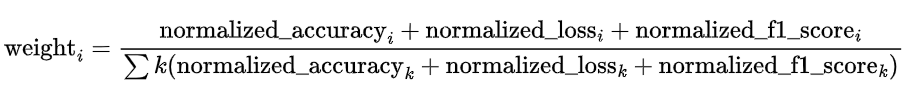

In [41]:
def calculate_weights(models, normalized_accuracies, normalized_losses, normalized_f1_scores):
    total_weight = sum(normalized_accuracies[k] + normalized_losses[k] + normalized_f1_scores[k] for k in models.keys())
    
    weights = {}
    for model_name in models.keys():
        weight = (normalized_accuracies[model_name] + normalized_losses[model_name] + normalized_f1_scores[model_name]) / total_weight
        weights[model_name] = weight
    
    # Normalize weights to ensure they sum up to 1
    total_weight = sum(weights.values())
    weights = {k: v / total_weight for k, v in weights.items()}
    
    # Calculate the remaining difference after rounding
    weight_sum = sum(weights.values())
    remaining = 1.0 - weight_sum
    
    if remaining > 0:
        # Add the remaining difference to the model with the highest weight
        max_weight_model = max(weights, key=weights.get)
        weights[max_weight_model] += remaining
    elif remaining < 0:
        # Subtract the remaining difference from the model with the lowest weight
        min_weight_model = min(weights, key=weights.get)
        weights[min_weight_model] += remaining
    
    for model_name in models.keys():
        print(f"Model:    {model_name:<20} - Weight: {weights[model_name]:.4f}")
        # print(f"     Weight:     {weights[model_name]:.4f}")
        # print(f"     Accuracy:   {accuracies[model_name]:.4f}")
        # print(f"     Precision:  {model_metrics[model_name]['precision']:.4f}")
        # print(f"     Recall:     {model_metrics[model_name]['recall']:.4f}")
        # print(f"     F1 Score:   {model_metrics[model_name]['f1']:.4f}")
        # print()
    
    return weights

time: 2.67 ms (started: 2024-09-03 13:45:51 -04:00)


###Weighted voting ensemble model formation

In [42]:
# def weighted_voting_ensemble(models, accuracies, losses, f1_scores, dataloader, threshold=0.5):
#     all_preds = []
#     all_labels = []
    
#     # Normalize metrics
#     normalized_accuracies, normalized_losses, normalized_f1_scores = normalize_metrics(accuracies, losses, f1_scores)
    
#     # Calculate weights
#     weights = calculate_weights(models, normalized_accuracies, normalized_losses, normalized_f1_scores)
    
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.to(device)
#             labels = labels.to(device)
            
#             # Initialize an array to store the weighted sum of probabilities
#             weighted_sum = np.zeros((images.size(0), num_classes))
            
#             for model_name, model in models.items():
#                 outputs = model(images)
#                 probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                
#                 # Use the pre-calculated weight for the current model
#                 weighted_sum += probabilities * weights[model_name]
            
#             # Normalize the weighted sum to get the final probabilities
#             final_probabilities = weighted_sum
#             max_probs = np.max(final_probabilities, axis=1)
#             predicted = np.argmax(final_probabilities, axis=1)
#             confident_preds = (max_probs >= threshold).astype(int) * predicted
            
#             all_preds.extend(confident_preds)
#             all_labels.extend(labels.cpu().numpy())
    
#     return all_preds, all_labels

time: 5.33 ms (started: 2024-09-03 13:45:51 -04:00)


In [43]:
def weighted_voting_ensemble(models, accuracies, losses, f1_scores, dataloader, threshold=0.5, is_test=False):
    all_preds = []
    all_labels = [] if not is_test else None
    all_confidences = []
    all_model_predictions = {model_name: [] for model_name in models.keys()}
    
    # Normalize metrics
    normalized_accuracies, normalized_losses, normalized_f1_scores = normalize_metrics(accuracies, losses, f1_scores)
    
    # Calculate weights
    weights = calculate_weights(models, normalized_accuracies, normalized_losses, normalized_f1_scores)
    
    with torch.no_grad():
        for batch in dataloader:
            if is_test:
                images = batch
            else:
                images, labels = batch
                labels = labels.to(device)
                all_labels.extend(labels.cpu().numpy())
            
            images = images.to(device)
            
            # Initialize an array to store the weighted sum of probabilities
            weighted_sum = np.zeros((images.size(0), num_classes))
            
            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                
                # Store the predictions of each component model
                all_model_predictions[model_name].extend(probabilities)
                
                # Use the pre-calculated weight for the current model
                weighted_sum += probabilities * weights[model_name]
            
            # Normalize the weighted sum to get the final probabilities
            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            predicted = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * predicted
            
            all_preds.extend(confident_preds)
            all_confidences.extend(max_probs)
    
    return all_preds, all_labels, all_confidences, all_model_predictions


time: 3.12 ms (started: 2024-09-03 13:45:51 -04:00)


###Visualization

In [44]:
def visualize_ensemble_validations(models, accuracies, dataloader, label_mapping, num_images=16, threshold=0.5):
    models = {name: model.eval() for name, model in models.items()}
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(18, num_images * 3))  # Increase the figure size

    total_accuracy = sum(accuracies.values())

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            weighted_sum = np.zeros((images.size(0), len(label_mapping)))
            model_predictions = {name: [] for name in models.keys()}

            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                weight = accuracies[model_name] / total_accuracy
                weighted_sum += probabilities * weight
                model_predictions[model_name] = probabilities

            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            preds = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * preds

            for j in range(images.size()[0]):
                if images_so_far == num_images:
                    plt.tight_layout()
                    return
                
                ax_img = axes[images_so_far, 0]
                ax_info = axes[images_so_far, 1]
                ax_img.axis('off')
                ax_info.axis('off')

                # Display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax_img.imshow(img)

                # Display the information
                image_name = dataloader.dataset.dataframe.iloc[j]['Image_Id']
                predicted_label = list(label_mapping.keys())[confident_preds[j]]
                actual_label = list(label_mapping.keys())[labels[j]]
                correctness = "Yes" if predicted_label == actual_label else "No"
                info_text = (f'{"Image:":<25} {image_name}\n'
                             f'{"Predicted:":<25} {predicted_label}\n'
                             f'{"Confidence:":<25} {max_probs[j]:.2f}\n'
                             f'{"Actual:":<25} {actual_label}\n'
                             f'{"Correctness:":<25} {correctness}\n'
                             f'{"Prediction of components:":<25}\n')
                
                for model_name, probs in model_predictions.items():
                    model_pred = np.argmax(probs[j])
                    model_prob = probs[j][model_pred]
                    info_text += f'{"- " + model_name + ":":<25} {list(label_mapping.keys())[model_pred]} ({model_prob:.2f})\n'
                
                ax_info.text(0, 0.5, info_text, fontsize=12, verticalalignment='center', family='monospace')  # Use fixed-width font

                images_so_far += 1

    plt.tight_layout()

time: 3.84 ms (started: 2024-09-03 13:45:51 -04:00)


In [70]:
def plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=False):
    # Create a reverse mapping from numerical labels to string labels
    reverse_label_mapping = {i: k for i, k in enumerate(disease_type_order)}
    
    # Map numerical labels to string labels
    ensemble_labels_str = [reverse_label_mapping[label] for label in ensemble_labels]
    ensemble_preds_str = [reverse_label_mapping[pred] for pred in ensemble_preds]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(ensemble_labels_str, ensemble_preds_str, labels=disease_type_order)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Convert the confusion matrix to a DataFrame for easier plotting
    cm_df = pd.DataFrame(cm, index=disease_type_order, columns=disease_type_order)
    
    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

time: 2.69 ms (started: 2024-09-03 13:59:11 -04:00)


In [45]:
def plot_false_predictions(ensemble_preds, ensemble_labels, dataloader, label_mapping, num_images=16):
    false_indices = [i for i, (pred, label) in enumerate(zip(ensemble_preds, ensemble_labels)) if pred != label]
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(18, num_images * 3))  # Increase the figure size

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if images_so_far >= num_images:
                break

            images = images.to(device)
            labels = labels.to(device)

            for j in range(images.size()[0]):
                if images_so_far >= num_images:
                    break

                idx = i * dataloader.batch_size + j
                if idx in false_indices:
                    ax_img = axes[images_so_far, 0]
                    ax_info = axes[images_so_far, 1]
                    ax_img.axis('off')
                    ax_info.axis('off')

                    # Display the image
                    img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img = np.clip(img, 0, 1)
                    ax_img.imshow(img)

                    # Display the information
                    image_name = dataloader.dataset.dataframe.iloc[idx]['Image_Id']
                    predicted_label = list(label_mapping.keys())[ensemble_preds[idx]]
                    actual_label = list(label_mapping.keys())[ensemble_labels[idx]]
                    info_text = (f'{"Image:":<25} {image_name}\n'
                                 f'{"Predicted:":<25} {predicted_label}\n'
                                 f'{"Actual:":<25} {actual_label}\n')
                    
                    ax_info.text(0, 0.5, info_text, fontsize=12, verticalalignment='center', family='monospace')  # Use fixed-width font

                    images_so_far += 1

    plt.tight_layout()
    plt.show()


time: 3 ms (started: 2024-09-03 13:45:51 -04:00)


In [46]:
def plot_false_predictions_distribution(ensemble_preds, ensemble_labels, train_groundtruth, label_mapping, disease_type_order):
    # Calculate false predictions
    false_preds = [label for pred, label in zip(ensemble_preds, ensemble_labels) if pred != label]

    # Count the occurrences of each class in false predictions
    false_counts = np.bincount(false_preds, minlength=len(label_mapping))

    # Convert to DataFrame for easier plotting
    false_counts_df = pd.DataFrame({'Disease Type': list(label_mapping.keys()), 'False Count': false_counts})
    false_counts_df = false_counts_df.set_index('Disease Type').reindex(disease_type_order).reset_index()

    # Print the number of data points per class
    disease_type_counts = train_groundtruth[disease_type_order].sum()
    print(disease_type_counts)

    # Plot the false predictions distribution
    plt.figure(figsize=(16, 8))
    sns.barplot(data=false_counts_df, x='Disease Type', y='False Count', palette='viridis')
    plt.title('False Predictions Distribution by Class')
    plt.xlabel('Disease Type')
    plt.ylabel('Number of False Predictions')
    plt.xticks(rotation=45)
    plt.show()

time: 1.71 ms (started: 2024-09-03 13:45:51 -04:00)


##Ensemble model formation

###Load models

In [47]:
# Define the model names and number of classes
# model_names = [ 'densenet121', 'efficientnet-b0', 'resnet50', 'resnext50_32x4d', 'shufflenet_v2_x1_0']
model_names = ['efficientnet-b0', 'shufflenet_v2_x1_0']
num_classes = 8
save_dir = '../t8_train_group/best_model'

# Load the models, their accuracies, and losses
models, accuracies, losses, learning_rates = load_saved_models(save_dir, model_names, num_classes)

Loaded models:

efficientnet-b0      - Accuracy 75.69% - Loss 0.7443 - Learning rate: 0.000000
shufflenet_v2_x1_0   - Accuracy 71.33% - Loss 0.8170 - Learning rate: 0.000000
time: 7 s (started: 2024-09-03 13:45:51 -04:00)


###Evaluate loaded models

In [48]:
# Evaluate each model and store the metrics
model_metrics = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    model_metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    print(f"{model_name:<20} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}")

print()

efficientnet-b0      - Accuracy: 0.7636 - Precision: 0.7686 - Recall: 0.7636 - F1 Score: 0.7647
shufflenet_v2_x1_0   - Accuracy: 0.7181 - Precision: 0.7276 - Recall: 0.7181 - F1 Score: 0.7210

time: 48.3 s (started: 2024-09-03 13:45:58 -04:00)


###Calculate the models weights and evaluate the ensemble model's performance

In [66]:
# Extract F1 scores from model_metrics
f1_scores = {model_name: metrics['f1'] for model_name, metrics in model_metrics.items()}

# Use the ensemble model to evaluate on the test dataset
ensemble_preds, ensemble_labels, _, _ = weighted_voting_ensemble(models, accuracies, losses, f1_scores, test_loader)

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(ensemble_labels, ensemble_preds) * 100
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}%')

# Print the classification report
report = classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys(), output_dict=True)
print(classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys()))

# Calculate specificity for each class
specificity = calculate_specificity(ensemble_labels, ensemble_preds, num_classes)
print("Specificity for each class:")
for class_name, spec in zip(label_mapping.keys(), specificity.values()):
    print(f"{class_name}: {spec:.4f}")
print()

# Calculate overall specificity
overall_specificity = sum(specificity.values()) / num_classes
print(f"Overall Specificity: {overall_specificity:.4f}")

Model:    efficientnet-b0      - Weight: 0.5176
Model:    shufflenet_v2_x1_0   - Weight: 0.4824
Ensemble Model Accuracy: 73.31%
                               precision    recall  f1-score   support

            Actinic Keratoses       0.20      0.69      0.31        85
         Basal Cell Carcinoma       0.81      0.80      0.80       325
Benign Keratosis-Like Lesions       0.67      0.64      0.65       230
               Dermatofibroma       0.78      0.61      0.68        23
             Melanocytic Nevi       0.90      0.78      0.84       975
                     Melanoma       0.73      0.67      0.70       410
      Squamous Cell Carcinoma       0.79      0.50      0.61        62
             Vascular Lesions       0.94      0.77      0.85        22

                     accuracy                           0.73      2132
                    macro avg       0.73      0.68      0.68      2132
                 weighted avg       0.80      0.73      0.76      2132

Specificity for e

In [67]:
# Calculate overall specificity
support = [report[class_name]['support'] for class_name in label_mapping.keys()]
overall_specificity = calculate_weighted_specificity(specificity, support)
print(f"Overall Specificity: {overall_specificity:.4f}")

# Extract overall precision and recall from the classification report
overall_precision = report['weighted avg']['precision']
overall_recall = report['weighted avg']['recall']

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")

Overall Specificity: 0.9409
Overall Precision: 0.7970
Overall Recall: 0.7331
time: 1.18 ms (started: 2024-09-03 13:57:36 -04:00)


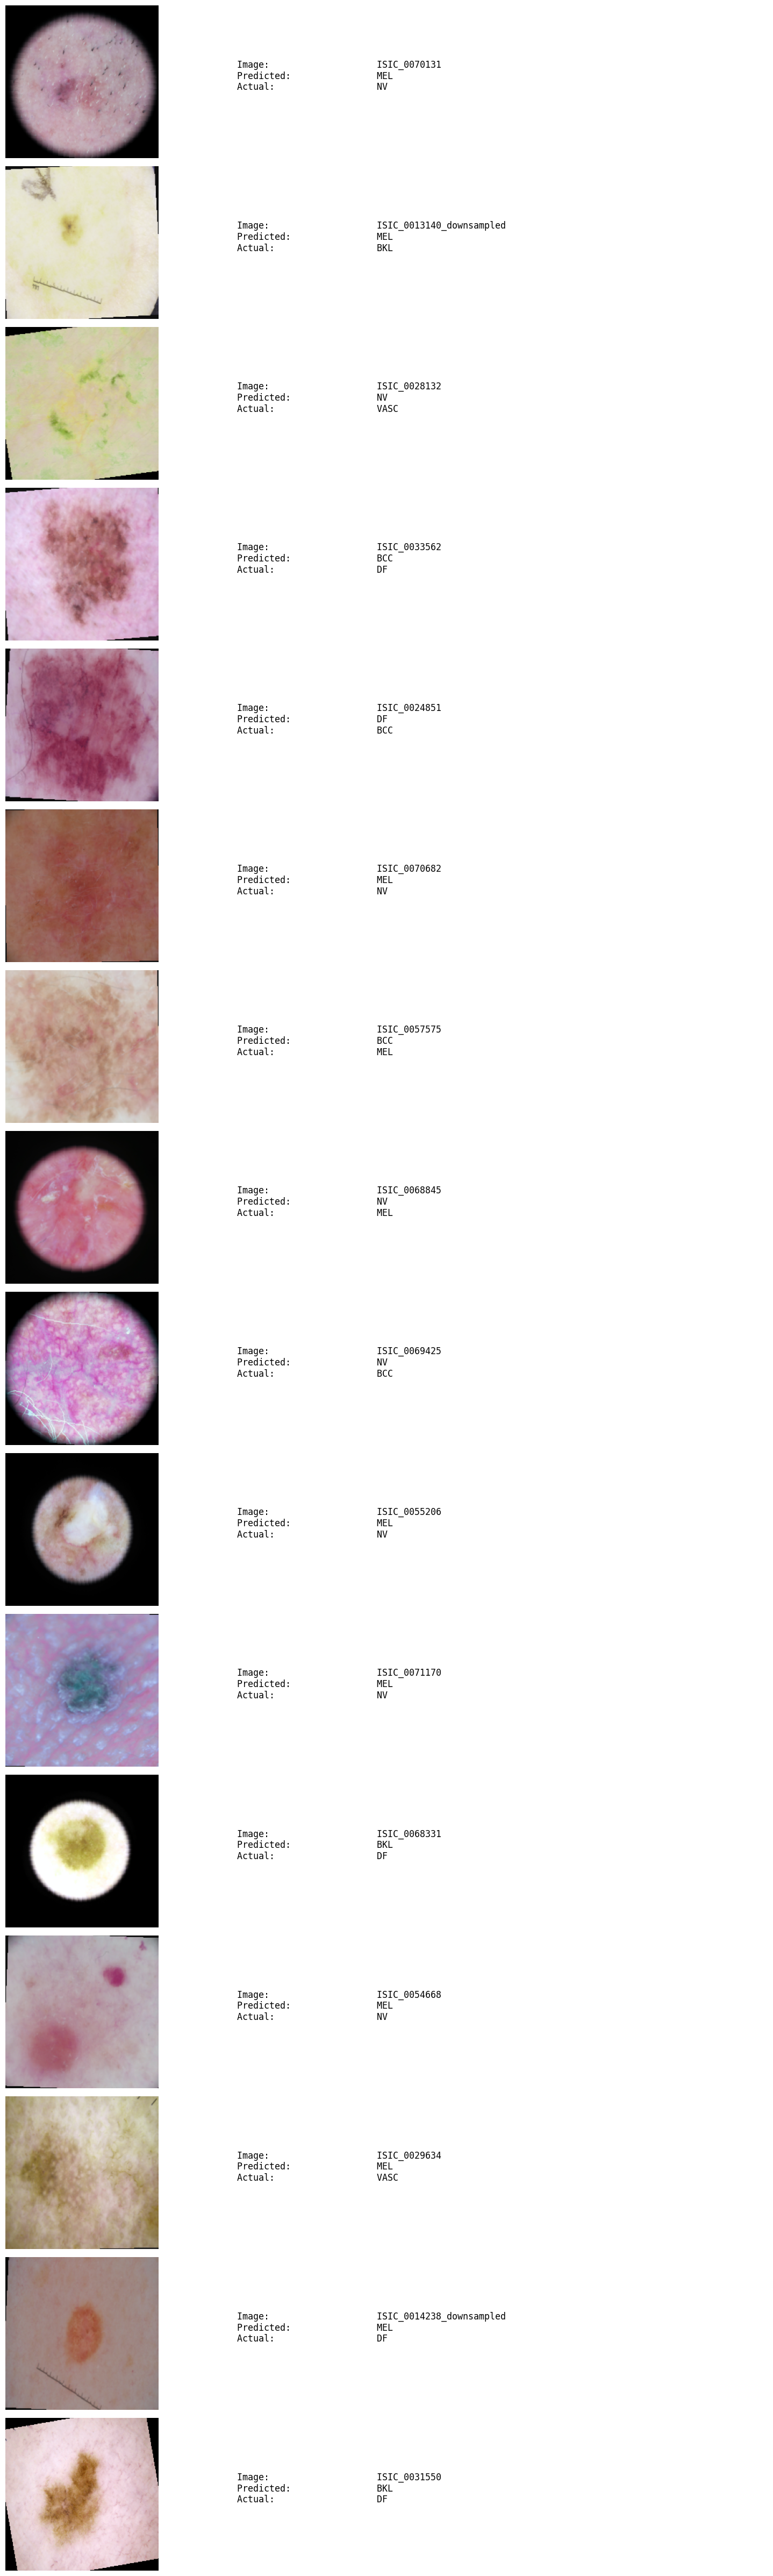

time: 4.54 s (started: 2024-09-03 14:08:05 -04:00)


In [89]:
# Call the function to plot false predictions
plot_false_predictions(ensemble_preds, ensemble_labels, test_loader, label_mapping)


##Plot Confusion Matrix

In [68]:
# # Define the order of classes
# disease_type_order = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# # Define the label mapping
# label_mapping = {
#     'MEL': 'Melanoma',
#     'NV': 'Melanocytic Nevi',
#     'BCC': 'Basal Cell Carcinoma',
#     'AK': 'Actinic Keratoses',
#     'BKL': 'Benign Keratosis-Like Lesions',
#     'DF': 'Dermatofibroma',
#     'VASC': 'Vascular Lesions',
#     'SCC': 'Squamous Cell Carcinoma',
#     'UNK': 'Unknown'
# }

# # Call the function to plot the false predictions distribution
# plot_false_predictions_distribution(ensemble_preds, ensemble_labels, train_groundtruth, label_mapping, disease_type_order)

time: 642 µs (started: 2024-09-03 13:59:09 -04:00)


In [79]:
# Define the order of classes
disease_type_order = ['Actinic Keratoses',
                      'Basal Cell Carcinoma',
                      'Benign Keratosis-Like Lesions',
                      'Dermatofibroma',
                      'Melanocytic Nevi',
                      'Melanoma',
                      'Squamous Cell Carcinoma',
                      'Vascular Lesions',]

time: 592 µs (started: 2024-09-03 14:03:17 -04:00)


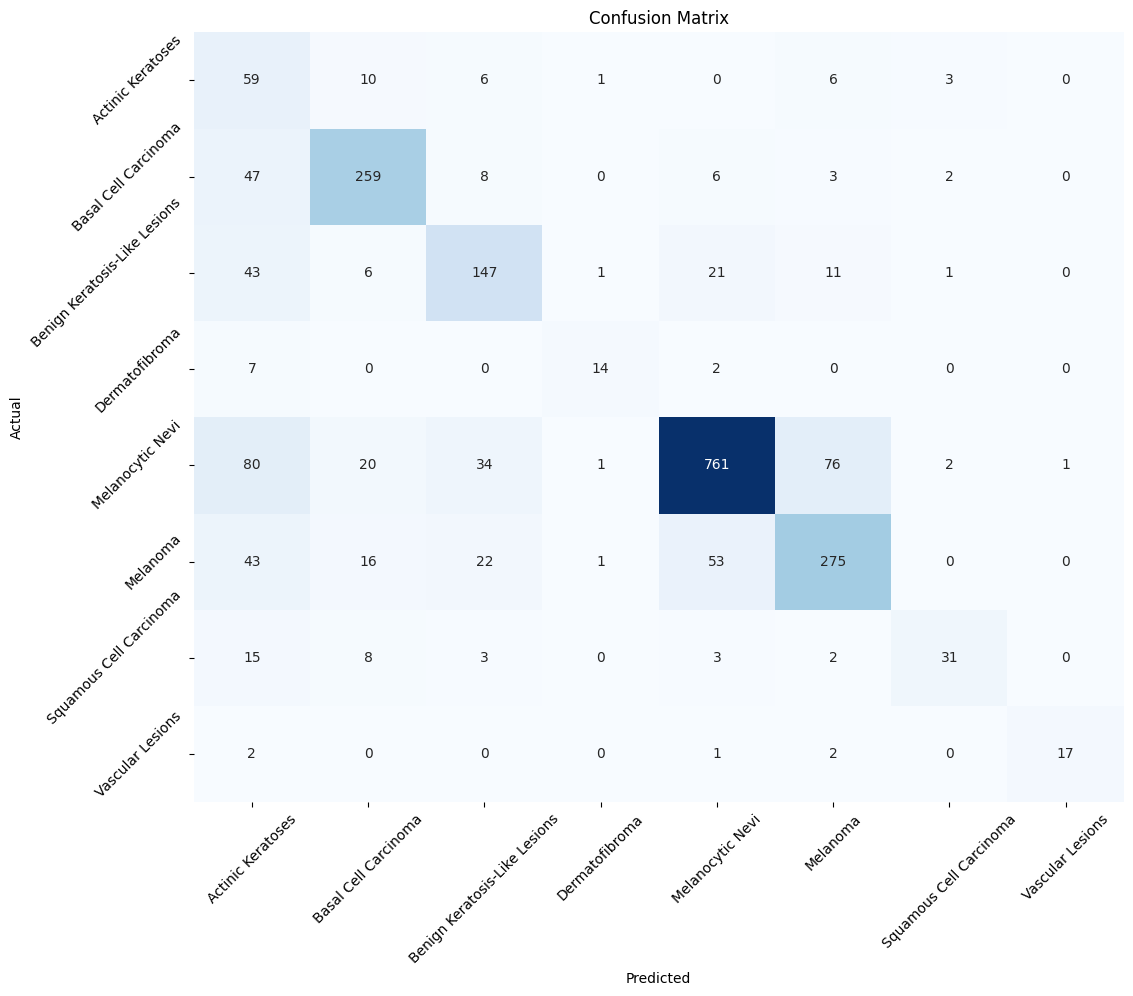

time: 440 ms (started: 2024-09-03 14:03:17 -04:00)


In [80]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=False)

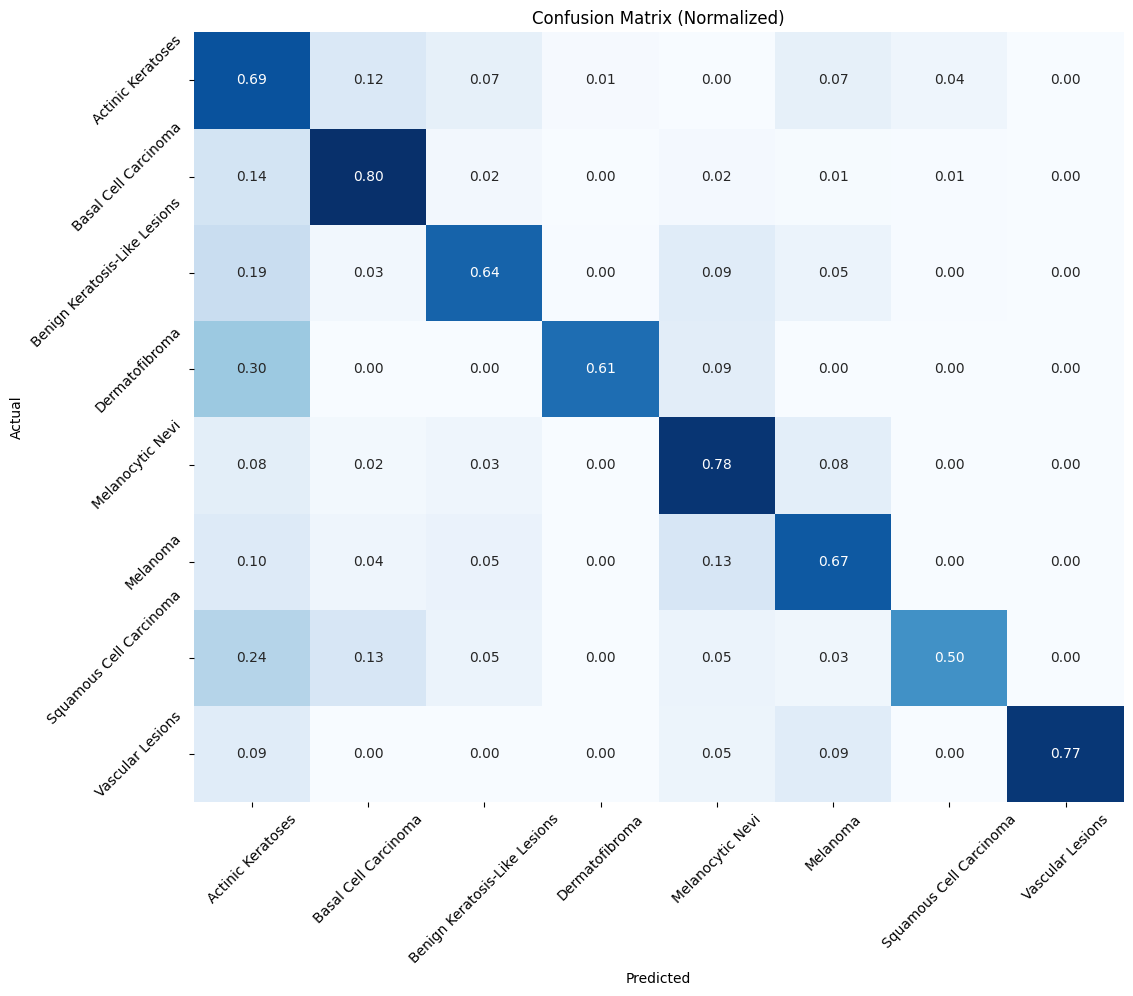

time: 427 ms (started: 2024-09-03 14:03:18 -04:00)


In [81]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=True)

In [86]:
# Define the order of classes
disease_type_order = ['AK',
                      'BCC',
                      'BKL',
                      'DF',
                      'NV',
                      'MEL',
                      'SCC',
                      'VASC',]

# Define the label mapping
label_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

time: 1.29 ms (started: 2024-09-03 14:06:09 -04:00)


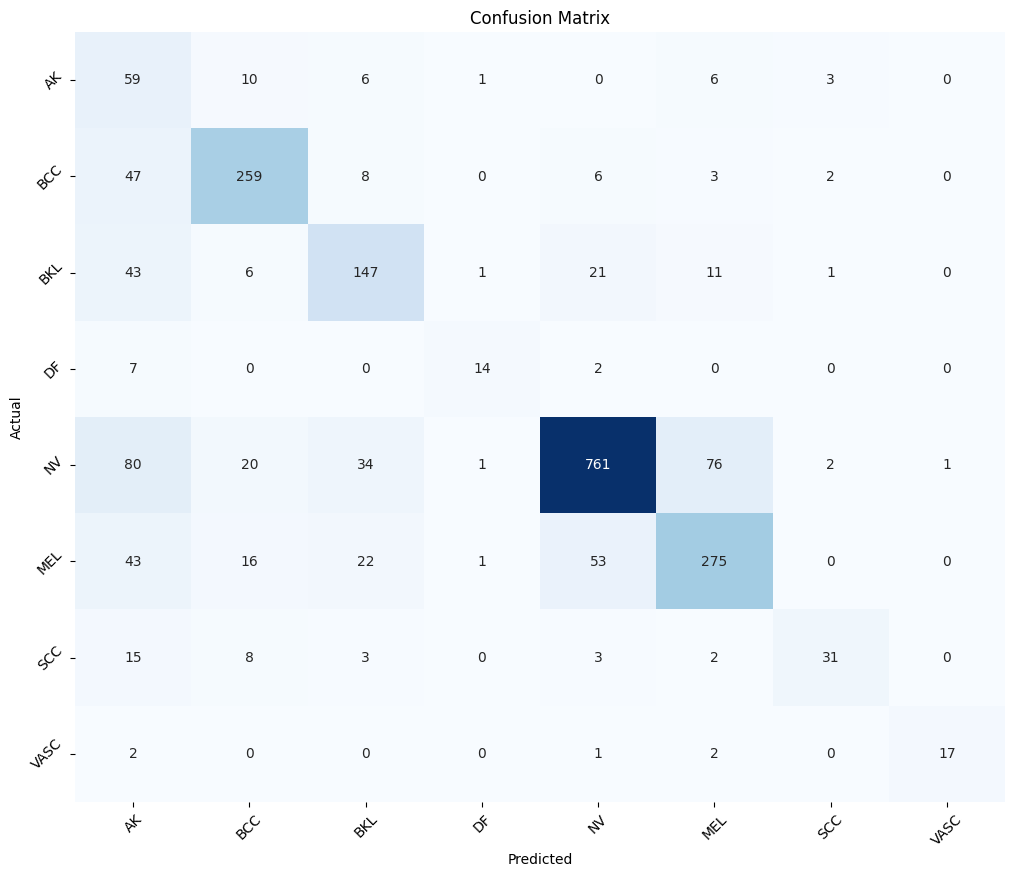

time: 336 ms (started: 2024-09-03 14:06:10 -04:00)


In [87]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=False)

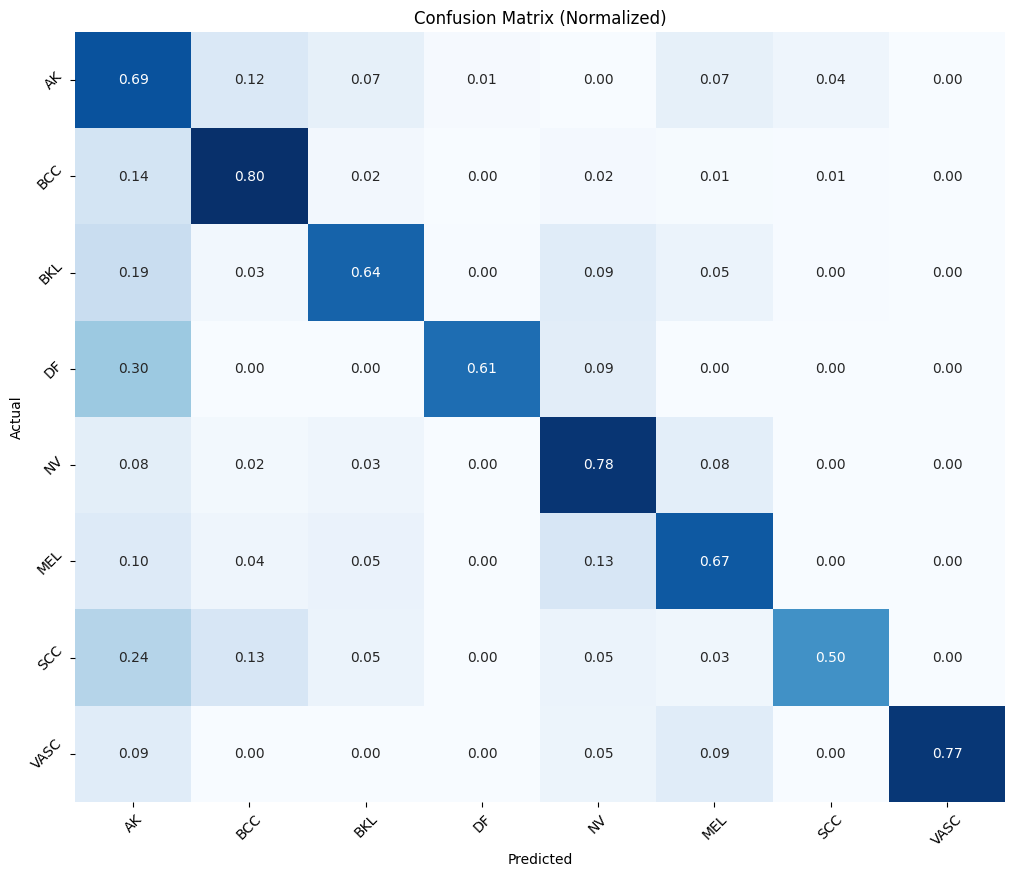

time: 345 ms (started: 2024-09-03 14:06:10 -04:00)


In [88]:
plot_confusion_matrix(ensemble_preds, ensemble_labels, label_mapping, disease_type_order, normalize=True)

/tmp/ipykernel_2127994/1595892993.py:12: RuntimeWarning: invalid value encountered in divide
  false_percentage = (false_counts / total_counts) * 100
/tmp/ipykernel_2127994/1595892993.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=false_percentage_df, x='Disease Type', y='False Percentage', palette='viridis')


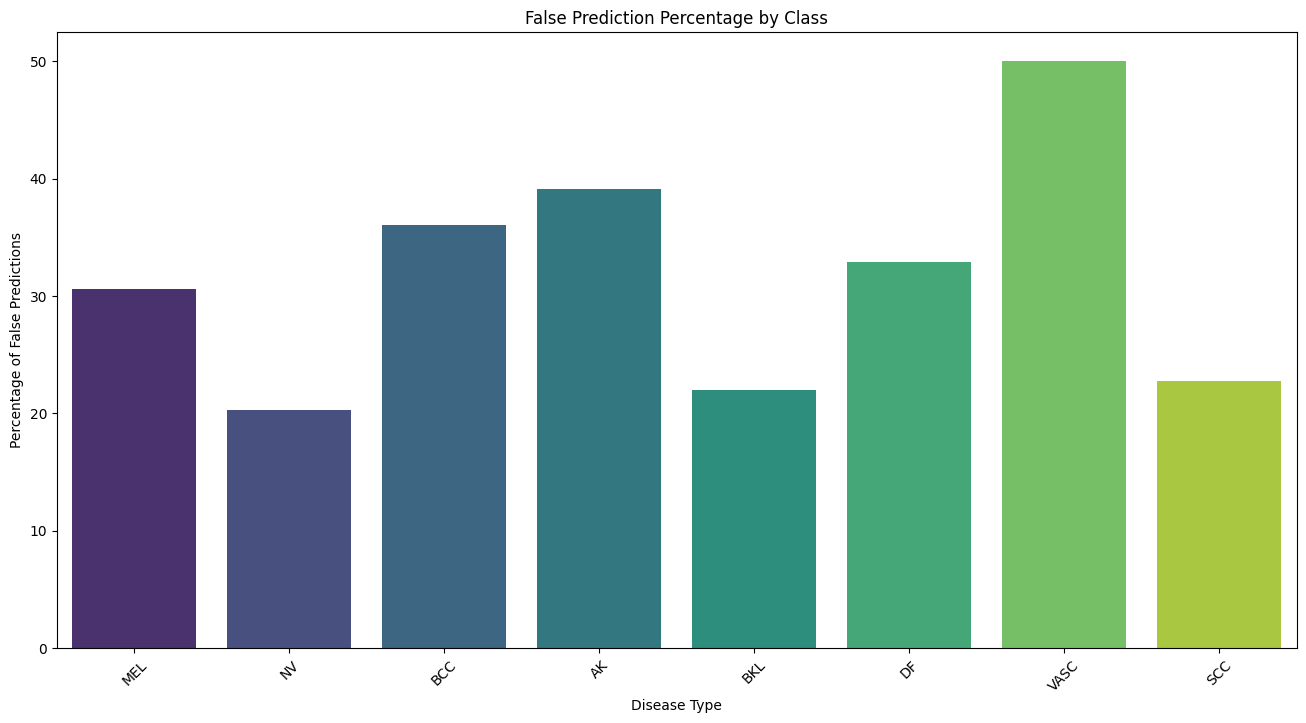

time: 340 ms (started: 2024-09-03 14:10:13 -04:00)


In [90]:
def plot_false_prediction_percentage(ensemble_preds, ensemble_labels, label_mapping, disease_type_order):
    # Calculate false predictions
    false_preds = [label for pred, label in zip(ensemble_preds, ensemble_labels) if pred != label]
    
    # Count the occurrences of each class in false predictions
    false_counts = np.bincount(false_preds, minlength=len(label_mapping))
    
    # Count the occurrences of each class in total predictions
    total_counts = np.bincount(ensemble_labels, minlength=len(label_mapping))
    
    # Calculate the percentage of false predictions for each class
    false_percentage = (false_counts / total_counts) * 100
    
    # Convert to DataFrame for easier plotting
    false_percentage_df = pd.DataFrame({'Disease Type': list(label_mapping.keys()), 'False Percentage': false_percentage})
    false_percentage_df = false_percentage_df.set_index('Disease Type').reindex(disease_type_order).reset_index()
    
    # Plot the false prediction percentage distribution
    plt.figure(figsize=(16, 8))
    sns.barplot(data=false_percentage_df, x='Disease Type', y='False Percentage', palette='viridis')
    plt.title('False Prediction Percentage by Class')
    plt.xlabel('Disease Type')
    plt.ylabel('Percentage of False Predictions')
    plt.xticks(rotation=45)
    plt.show()

# Define the order of classes
disease_type_order = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Define the label mapping
label_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Call the function to plot the false prediction percentage distribution
plot_false_prediction_percentage(ensemble_preds, ensemble_labels, label_mapping, disease_type_order)


/tmp/ipykernel_2127994/1628404902.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=false_counts_df, x='Disease Type', y='False Count', palette='viridis')


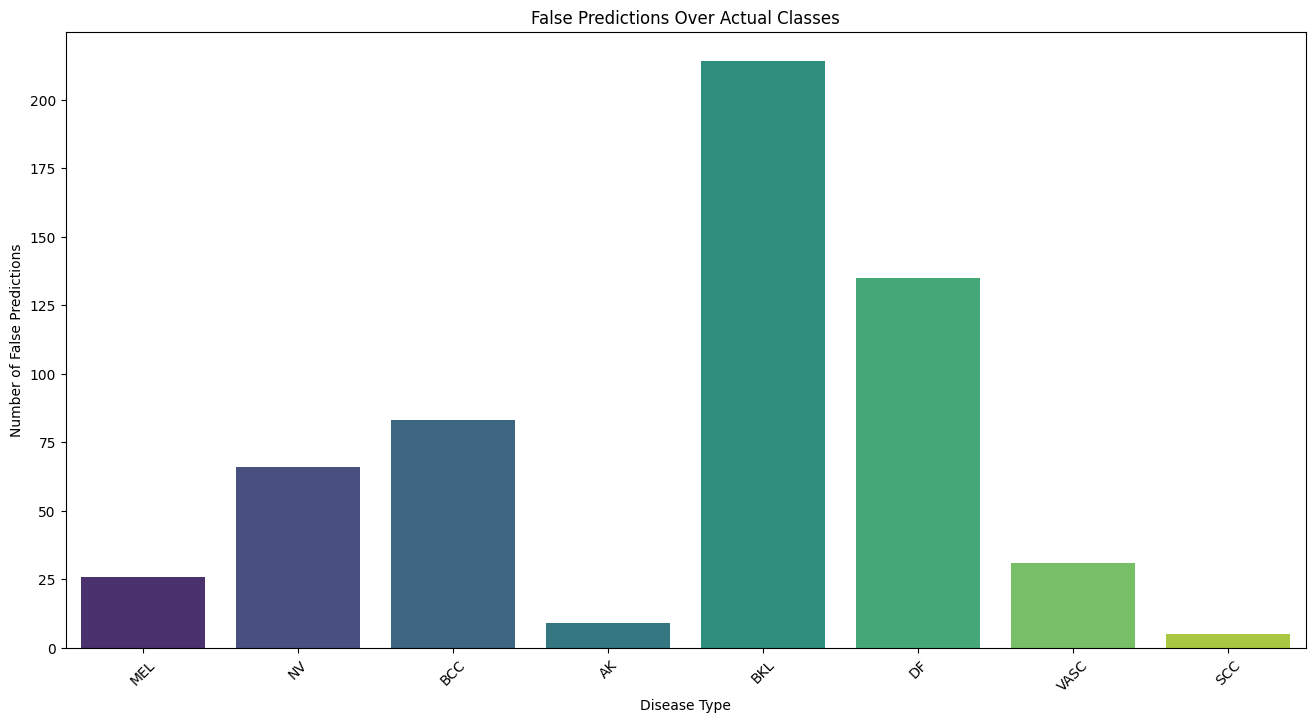

time: 301 ms (started: 2024-09-03 14:10:24 -04:00)


In [91]:
def plot_false_predictions_over_actual(ensemble_preds, ensemble_labels, label_mapping, disease_type_order):
    # Calculate false predictions
    false_preds = [label for pred, label in zip(ensemble_preds, ensemble_labels) if pred != label]
    false_actuals = [actual for pred, actual in zip(ensemble_preds, ensemble_labels) if pred != actual]

    # Count the occurrences of each class in false predictions
    false_counts = np.bincount(false_actuals, minlength=len(label_mapping))

    # Convert to DataFrame for easier plotting
    false_counts_df = pd.DataFrame({'Disease Type': list(label_mapping.keys()), 'False Count': false_counts})
    false_counts_df = false_counts_df.set_index('Disease Type').reindex(disease_type_order).reset_index()

    # Plot the false predictions distribution over actual classes
    plt.figure(figsize=(16, 8))
    sns.barplot(data=false_counts_df, x='Disease Type', y='False Count', palette='viridis')
    plt.title('False Predictions Over Actual Classes')
    plt.xlabel('Disease Type')
    plt.ylabel('Number of False Predictions')
    plt.xticks(rotation=45)
    plt.show()

# # Define the order of classes
# disease_type_order = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# # Define the label mapping
# label_mapping = {
#     'MEL': 'Melanoma',
#     'NV': 'Melanocytic Nevi',
#     'BCC': 'Basal Cell Carcinoma',
#     'AK': 'Actinic Keratoses',
#     'BKL': 'Benign Keratosis-Like Lesions',
#     'DF': 'Dermatofibroma',
#     'VASC': 'Vascular Lesions',
#     'SCC': 'Squamous Cell Carcinoma',
#     'UNK': 'Unknown'
# }

# Call the function to plot the false predictions over actual classes
plot_false_predictions_over_actual(ensemble_preds, ensemble_labels, label_mapping, disease_type_order)


###Visualize the ensemble model validations

In [93]:
# # Visualize the validations made by ensemble model
# visualize_ensemble_validations(models, accuracies, val_loader, label_mapping)

time: 559 µs (started: 2024-09-03 14:11:14 -04:00)


##Start ensemble model predictions

In [94]:
# Use the ensemble model to make predictions on the test dataset
ensemble_preds, _, confidences, model_predictions = weighted_voting_ensemble(models, accuracies, losses, f1_scores, prediction_test_loader, is_test=True)

# Map the predicted labels back to their original class names
predicted_labels = label_encoder.inverse_transform(ensemble_preds)

# Add the predictions to the test metadata DataFrame
test_metadata_pp['Predicted_Diagnosis'] = predicted_labels
test_metadata_pp['Confidence'] = confidences

# Display the test metadata with predictions
print(test_metadata_pp[['Image_Id', 'Age', 'Region_Of_Disease', 'Sex', 'Predicted_Diagnosis', 'Confidence']])

Model:    efficientnet-b0      - Weight: 0.5176
Model:    shufflenet_v2_x1_0   - Weight: 0.4824
          Image_Id  Age Region_Of_Disease     Sex  \
1     ISIC_0034322   70    anterior torso    male   
2     ISIC_0034323   70   lower extremity    male   
3     ISIC_0034324   70   lower extremity    male   
4     ISIC_0034325   30   upper extremity  female   
5     ISIC_0034326   80         head/neck    male   
...            ...  ...               ...     ...   
8233  ISIC_0073236   75    anterior torso    male   
8234  ISIC_0073243   65   lower extremity    male   
8235  ISIC_0073250   30    anterior torso  female   
8236  ISIC_0073252   85         head/neck  female   
8237  ISIC_0073253   70    anterior torso    male   

                Predicted_Diagnosis  Confidence  
1     Benign Keratosis-Like Lesions    0.588453  
2                 Actinic Keratoses    0.367339  
3                  Melanocytic Nevi    0.926070  
4     Benign Keratosis-Like Lesions    0.721609  
5     Benign Kera

Name of image: ISIC_0034322
Final prediction of ensemble model: Benign Keratosis-Like Lesions
Confidence: 0.5885
Final prediction of efficientnet-b0: Melanoma with probability 0.5570
Final prediction of shufflenet_v2_x1_0: Benign Keratosis-Like Lesions with probability 0.9618


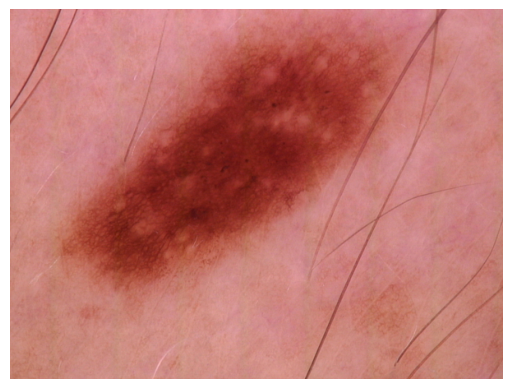

Name of image: ISIC_0034323
Final prediction of ensemble model: Actinic Keratoses
Confidence: 0.3673
Final prediction of efficientnet-b0: Benign Keratosis-Like Lesions with probability 0.3590
Final prediction of shufflenet_v2_x1_0: Basal Cell Carcinoma with probability 0.4473


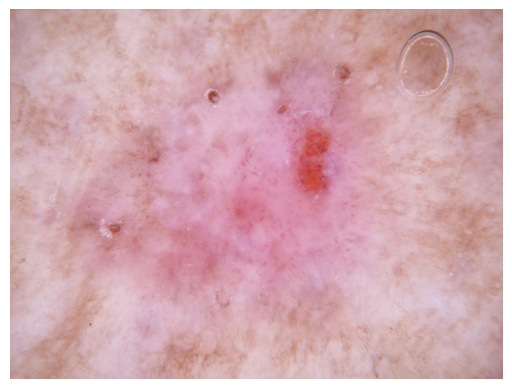

Name of image: ISIC_0034324
Final prediction of ensemble model: Melanocytic Nevi
Confidence: 0.9261
Final prediction of efficientnet-b0: Melanocytic Nevi with probability 0.9950
Final prediction of shufflenet_v2_x1_0: Melanocytic Nevi with probability 0.8522


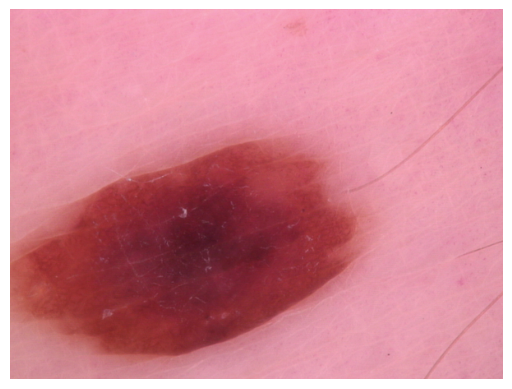

Name of image: ISIC_0034325
Final prediction of ensemble model: Benign Keratosis-Like Lesions
Confidence: 0.7216
Final prediction of efficientnet-b0: Benign Keratosis-Like Lesions with probability 0.6208
Final prediction of shufflenet_v2_x1_0: Benign Keratosis-Like Lesions with probability 0.8298


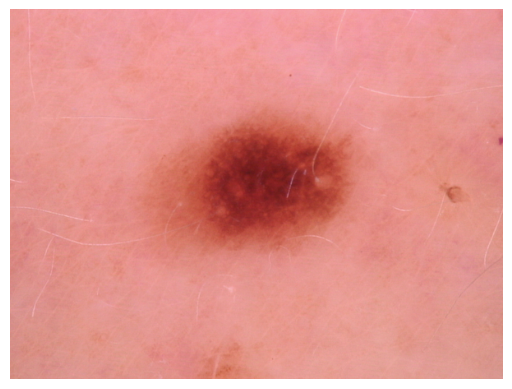

Name of image: ISIC_0034326
Final prediction of ensemble model: Benign Keratosis-Like Lesions
Confidence: 0.9849
Final prediction of efficientnet-b0: Benign Keratosis-Like Lesions with probability 0.9983
Final prediction of shufflenet_v2_x1_0: Benign Keratosis-Like Lesions with probability 0.9705


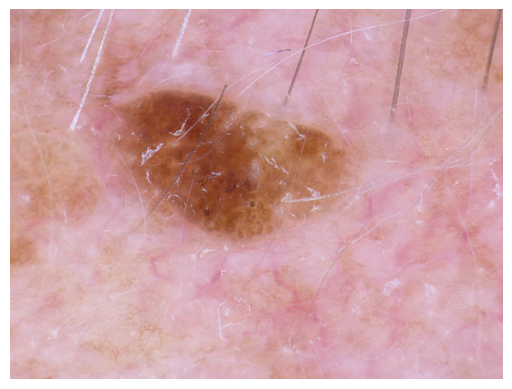

time: 1.01 s (started: 2024-09-03 14:13:34 -04:00)


In [95]:
# Print images with information
for idx in range(5):  # Change the range to display more or fewer images
    image_info = test_metadata_pp.iloc[idx]
    image_path = image_info['Image_path']
    image = Image.open(image_path)
    
    print(f"Name of image: {image_info['Image_Id']}")
    print(f"Final prediction of ensemble model: {image_info['Predicted_Diagnosis']}")
    print(f"Confidence: {image_info['Confidence']:.4f}")
    
    for model_name in models.keys():
        model_probabilities = model_predictions[model_name][idx]
        model_prediction = label_encoder.inverse_transform([np.argmax(model_probabilities)])[0]
        model_confidence = np.max(model_probabilities)
        print(f"Final prediction of {model_name}: {model_prediction} with probability {model_confidence:.4f}")
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
class FeedbackSystem:
    def __init__(self, initial_points=100):
        self.trustworthy_points = initial_points

    def update_trustworthy_points(self, feedback):
        if feedback == 1:
            self.trustworthy_points = min(self.trustworthy_points + 1, 100)
        elif feedback == 0:
            self.trustworthy_points = max(self.trustworthy_points - 1, 0)

    def get_trustworthy_points(self):
        return self.trustworthy_points

# Initialize the feedback system
feedback_system = FeedbackSystem()

# Function to get user feedback
def get_user_feedback(image_id, predicted_label, confidence, trustworthy_points):
    print(f"Image ID: {image_id}")
    print(f"Predicted Diagnosis: {predicted_label}")
    print(f"Confidence: {confidence * 100:.2f}%")
    print(f"Trustworthy: {trustworthy_points}%")
    feedback = input("Is the prediction correct? (1 for Yes, 0 for No, press Enter to skip): ")
    return feedback

# Iterate through the test dataset and collect feedback
for idx, row in test_metadata_pp.iterrows():
    image_id = row['Image_Id']
    predicted_label = row['Predicted_Diagnosis']
    confidence = row['Confidence']
    
    # Print trustworthy points when predicting the image
    feedback = get_user_feedback(image_id, predicted_label, confidence, feedback_system.get_trustworthy_points())
    
    if feedback:
        feedback = int(feedback)
        feedback_system.update_trustworthy_points(feedback)
    
    print(f"Updated Trustworthy Points: {feedback_system.get_trustworthy_points()}%\n")

# Final trustworthy points
print(f"Final Trustworthy Points: {feedback_system.get_trustworthy_points()}%")
